In [3]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

data_folder = Path("./titanic")
test_path = data_folder / "test.csv"
train_path = data_folder / "train.csv"

In [4]:
data_original = pd.read_csv(train_path)

In [5]:
data = data_original.copy()

In [6]:
data.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
684,685,0,2,"Brown, Mr. Thomas William Solomon",male,60.0,1,1,29750,39.0000,NaN,S
130,131,0,3,"Drazenoic, Mr. Jozef",male,33.0,0,0,349241,7.8958,NaN,C
322,323,1,2,"Slayter, Miss. Hilda Mary",female,30.0,0,0,234818,12.3500,NaN,Q
14,15,0,3,"Vestrom, Miss. Hulda Amanda Adolfina",female,14.0,0,0,350406,7.8542,NaN,S
563,564,0,3,"Simmons, Mr. John",male,NaN,0,0,SOTON/OQ 392082,8.0500,NaN,S


In [7]:
data.drop(columns=["Name", "PassengerId", "Embarked"], inplace=True)

In [8]:
data.dtypes

Survived      int64
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
dtype: object

In [9]:
for col in data.select_dtypes(exclude="number"):
    print(f"{col}:\n{data[col].value_counts()}\n")

Sex:
male      577
female    314
Name: Sex, dtype: int64

Ticket:
347082             7
1601               7
CA. 2343           7
347088             6
CA 2144            6
                  ..
234360             1
PC 17474           1
14311              1
SOTON/OQ 392086    1
250643             1
Name: Ticket, Length: 681, dtype: int64

Cabin:
G6             4
B96 B98        4
C23 C25 C27    4
F33            3
D              3
              ..
E38            1
C32            1
C62 C64        1
A32            1
T              1
Name: Cabin, Length: 147, dtype: int64



In [10]:
data.drop(columns=["Ticket", "Cabin"], inplace=True)

In [11]:
data["Sex"] = data["Sex"].astype("category")

In [12]:
data.dtypes

Survived       int64
Pclass         int64
Sex         category
Age          float64
SibSp          int64
Parch          int64
Fare         float64
dtype: object

In [13]:
data.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
dtype: int64

<AxesSubplot:xlabel='Age', ylabel='Count'>

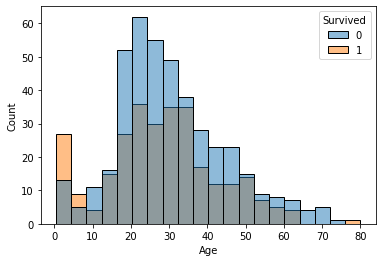

In [14]:
sn.histplot(data=data, x="Age", hue="Survived")

In [15]:
from sklearn.impute import KNNImputer

age_imputer = KNNImputer(n_neighbors=5)
age_imputer.fit(data.select_dtypes("number"))

KNNImputer()

In [16]:
data[[c for c in data.select_dtypes("number").columns]] = age_imputer.transform(data.select_dtypes("number"))

<AxesSubplot:xlabel='Age', ylabel='Count'>

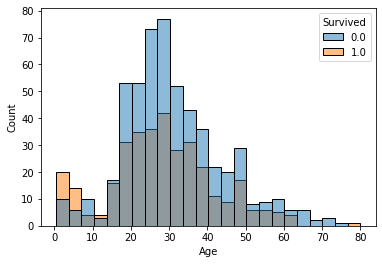

In [17]:
sn.histplot(data=data, x="Age", hue="Survived")

In [18]:
data.sample(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
581,1.0,1.0,female,39.0,1.0,1.0,110.8833
32,1.0,3.0,female,21.0,0.0,0.0,7.7500
372,0.0,3.0,male,19.0,0.0,0.0,8.0500
398,0.0,2.0,male,23.0,0.0,0.0,10.5000
394,1.0,3.0,female,24.0,0.0,2.0,16.7000


Survived
Pclass
Age
SibSp
Parch
Fare


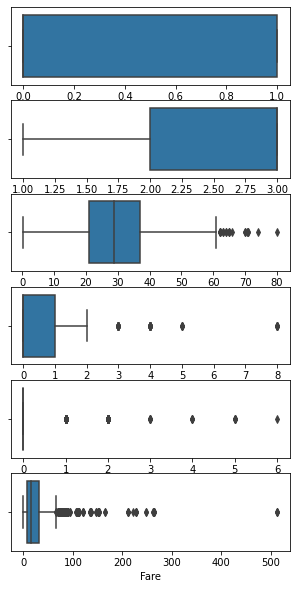

In [19]:
cols = [c for c in data.select_dtypes("number")]

fig, axis = plt.subplots(nrows=len(cols))
fig.set_size_inches(5, 10)

for col, ax in zip(cols, axis):
    print(col)
    sn.boxplot(data=data, x=col, ax=ax)

In [20]:
for col in data.select_dtypes("category"):
    print(f"{col}:\n{data[col].value_counts()}")

Sex:
male      577
female    314
Name: Sex, dtype: int64


In [21]:
data["Sex"] = data["Sex"].cat.codes

In [62]:
data = data.reindex(sorted(data.columns), axis=1)

Готуємо колонки до кластеризації

In [63]:
from sklearn.model_selection import train_test_split

x, y = data[data.columns.difference(["Survived"])], data["Survived"]
x, y

(      Age     Fare  Parch  Pclass Sex  SibSp
 0    22.0   7.2500    0.0     3.0   1    1.0
 1    38.0  71.2833    0.0     1.0   0    1.0
 2    26.0   7.9250    0.0     3.0   0    0.0
 3    35.0  53.1000    0.0     1.0   0    1.0
 4    35.0   8.0500    0.0     3.0   1    0.0
 ..    ...      ...    ...     ...  ..    ...
 886  27.0  13.0000    0.0     2.0   1    0.0
 887  19.0  30.0000    0.0     1.0   0    0.0
 888  26.8  23.4500    2.0     3.0   0    1.0
 889  26.0  30.0000    0.0     1.0   1    0.0
 890  32.0   7.7500    0.0     3.0   1    0.0
 
 [891 rows x 6 columns],
 0      0.0
 1      1.0
 2      1.0
 3      1.0
 4      0.0
       ... 
 886    0.0
 887    1.0
 888    0.0
 889    1.0
 890    0.0
 Name: Survived, Length: 891, dtype: float64)

In [64]:
from sklearn.cluster import KMeans, ward_tree, spectral_clustering
from sklearn.metrics import f1_score

In [65]:
def test_cluster(cluster, x_tr, x_ts, y_tr, y_ts):
    cluster.fit(x_tr)
    y_res = cluster.predict(x_ts)
    print(f"f1: {f1_score(y_ts, y_res)}")

In [66]:
model = KMeans(n_clusters=2, random_state=15)
test_cluster(model, *train_test_split(x, y, test_size=0.2, stratify=y, random_state=10))

f1: 0.17721518987341772


In [67]:
# depends on fitted "age_imputer"
def prepare_data(x_start):
    x = x_start.copy()
    x.drop(columns=["Name", "PassengerId", "Embarked", "Ticket", "Cabin"], inplace=True)
    x["Sex"] = x["Sex"].astype("category").cat.codes
    if "Survived" in x.columns:
        x.drop(columns=["Survived"], inplace=True)
    x[[c for c in x.select_dtypes("number").columns]] = age_imputer.transform(x.select_dtypes("number"))
    x = x.reindex(sorted(x.columns), axis=1)
    return x

In [76]:
data_test = pd.read_csv(test_path)
data_eval = prepare_data(data_test)
data_eval.sample()

,Age,Fare,Parch,Pclass,Sex,SibSp
116,21.6,6.4375,0.0,3.0,1.0,0.0


In [80]:
predictions = model.predict(data_eval)
predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [81]:
result = pd.DataFrame(index=data_test["PassengerId"])
result["Survived"] = predictions
result.to_csv("results.csv")
result

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,0
...,...
1305,0
1306,0
1307,0
